<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/CN/Bonus_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Autoencoder extensions
**Bonus Day: Autoencoders**

**By Neuromatch Academy**

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team (2014-2018)

__Content reviewers:__ Itzel Olivos, Karen Schroeder, Karolina Stosio, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom

---
# Setup
Please execute the cell(s) below to initialize the notebook environment.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn.datasets import fetch_openml

In [3]:
# @title Figure settings
!pip install plotly --quiet
import plotly.graph_objects as go
from plotly.colors import qualitative
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [4]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy())

  return weights


def print_parameter_count(net):
  """
  Prints count of learnable parameters per layer from PyTorch network.

  Args:
    net (torch.Sequential)
        Pytorch network

  Returns:
    Nothing.
  """

  params_n = 0

  # loop all layers in network
  for layer_idx, layer in enumerate(net):

    # retrieve learnable parameters
    weights = get_layer_weights(layer)
    params_layer_n = 0

    # loop list of learnable parameters and count them
    for params in weights:
      params_layer_n += params.size

    params_n += params_layer_n
    print(f'{layer_idx}\t {params_layer_n}\t {layer}')

  print(f'\nTotal:\t {params_n}')


def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.BCELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1]+list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

    plt.tight_layout()


def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates

  Returns:
    Sperical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:, 0], u[:, 1], u[:, 2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).

  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2

  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:, 0], s[:, 1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0] * n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)

      if s2:
        latent = to_u3(latent)

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j * image_shape[0]: (j + 1) * image_shape[0],
             i * image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)

  if s2:
    if xy_labels is None:
      xy_labels = [r'$\varphi$', r'$\theta$']

    plt.xticks(np.arange(0, np.pi + np.pi / 6, np.pi / 6),
               ['0', '$\pi/6$', '$\pi/3$', '$\pi/2$',
                '$2\pi/3$', '$5\pi/6$', '$\pi$'])
    plt.yticks(np.arange(-np.pi, np.pi + np.pi / 3, np.pi / 3),
               ['$-\pi$', '$-2\pi/3$', '$-\pi/3$', '0',
                '$\pi/3$', '$2\pi/3$', '$\pi$'])

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False,
                           title=None, xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, s2=s2, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


def plot_latent_3d(my_x, my_y, show_text=True, show_n=500):
  """
  Plot digit class or marker in 3D latent space coordinates.

  Args:
    my_x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    my_y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    show_text (boolean)
        whether to show text

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

  Returns:
    Nothing.
  """

  layout = {'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0},
            'scene': {'xaxis': {'showspikes': False,
                                'title': 'z1'},
                      'yaxis': {'showspikes': False,
                                'title': 'z2'},
                      'zaxis': {'showspikes': False,
                                'title': 'z3'}}
            }

  selected_idx = np.random.choice(len(my_x), show_n, replace=False)

  colors = [qualitative.T10[idx] for idx in my_y[selected_idx]]

  x = my_x[selected_idx, 0]
  y = my_x[selected_idx, 1]
  z = my_x[selected_idx, 2]

  text = my_y[selected_idx]

  if show_text:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         mode='text',
                         textfont={'color': colors, 'size': 12}
                         )

    layout['hovermode'] = False

  else:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         hoverinfo='text', mode='markers',
                         marker={'size': 5, 'color': colors, 'opacity': 0.8}
                         )

  fig = go.Figure(data=trace, layout=layout)

  fig.show()


def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()


class NormalizeLayer(nn.Module):
  """
  pyTorch layer (nn.Module) that normalizes activations by their L2 norm.

  Args:
      None.

  Returns:
      Object inherited from nn.Module class.
  """

  def __init__(self):
    super().__init__()

  def forward(self, x):
    return nn.functional.normalize(x, p=2, dim=1)

---
# Section 1: Download  and prepare MNIST dataset

In [5]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape image \t \t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape image 	 	 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


---
# Section 2: Deeper autoencoder (2D)

In [6]:
# to_remove solution
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size * 32, encoding_size),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size, encoding_size * 32),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(int(input_size / 2), input_size),
    # Add activation function
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
n_l = 6

# uncomment when you fill the code
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
)

Decoder 

 Sequential(
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_feat

In [7]:
help(print_parameter_count)

Help on function print_parameter_count in module __main__:

print_parameter_count(net)
    Prints count of learnable parameters per layer from PyTorch network.
    
    Args:
      net (torch.Sequential)
          Pytorch network
    
    Returns:
      Nothing.



Epoch 	 Loss train 	 Loss test
1/10	 0.2067		 0.2070
2/10	 0.1945		 0.1945
3/10	 0.1892		 0.1890
4/10	 0.1850		 0.1853
5/10	 0.1827		 0.1833
6/10	 0.1800		 0.1807
7/10	 0.1784		 0.1792
8/10	 0.1769		 0.1781
9/10	 0.1767		 0.1780
10/10	 0.1749		 0.1765


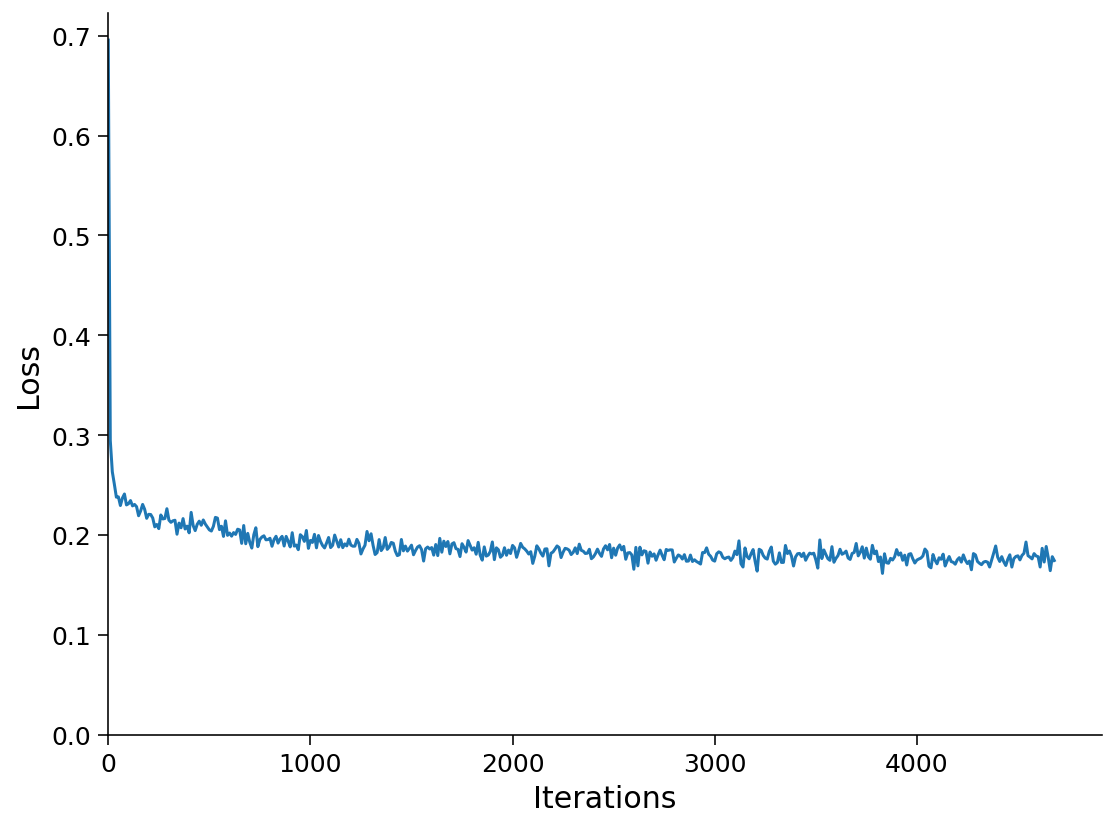

In [8]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

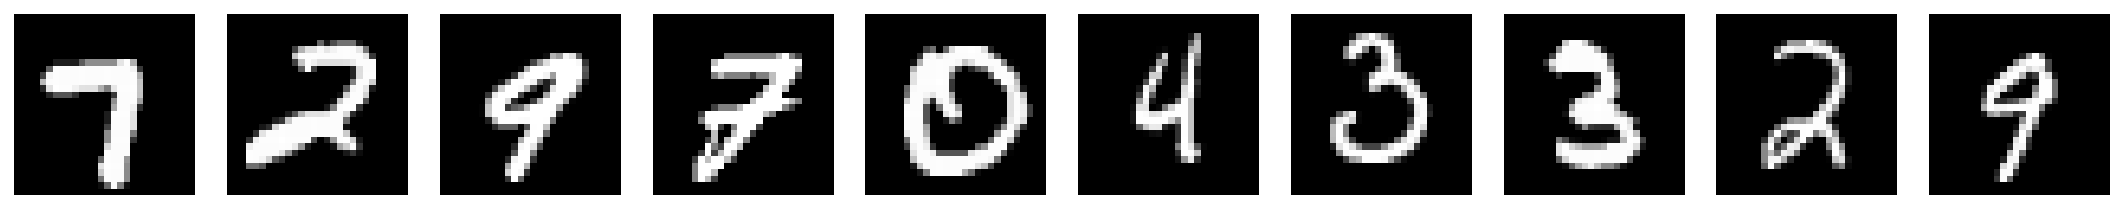

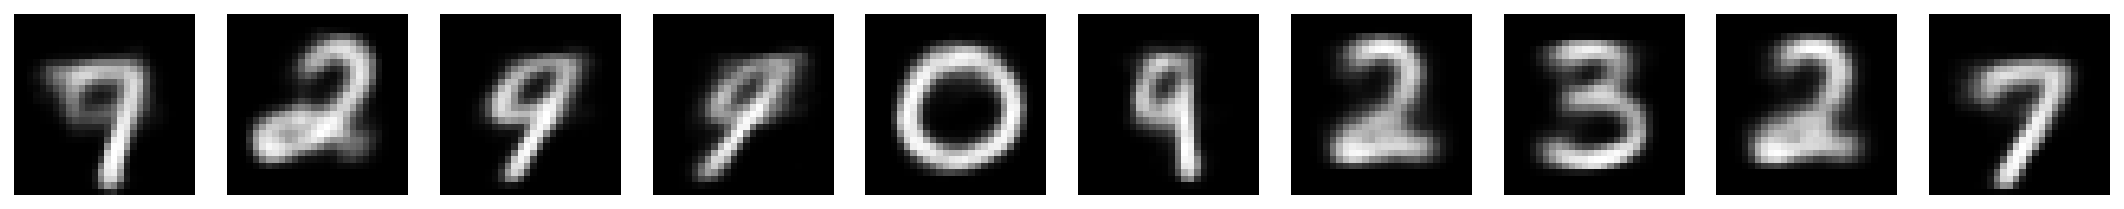

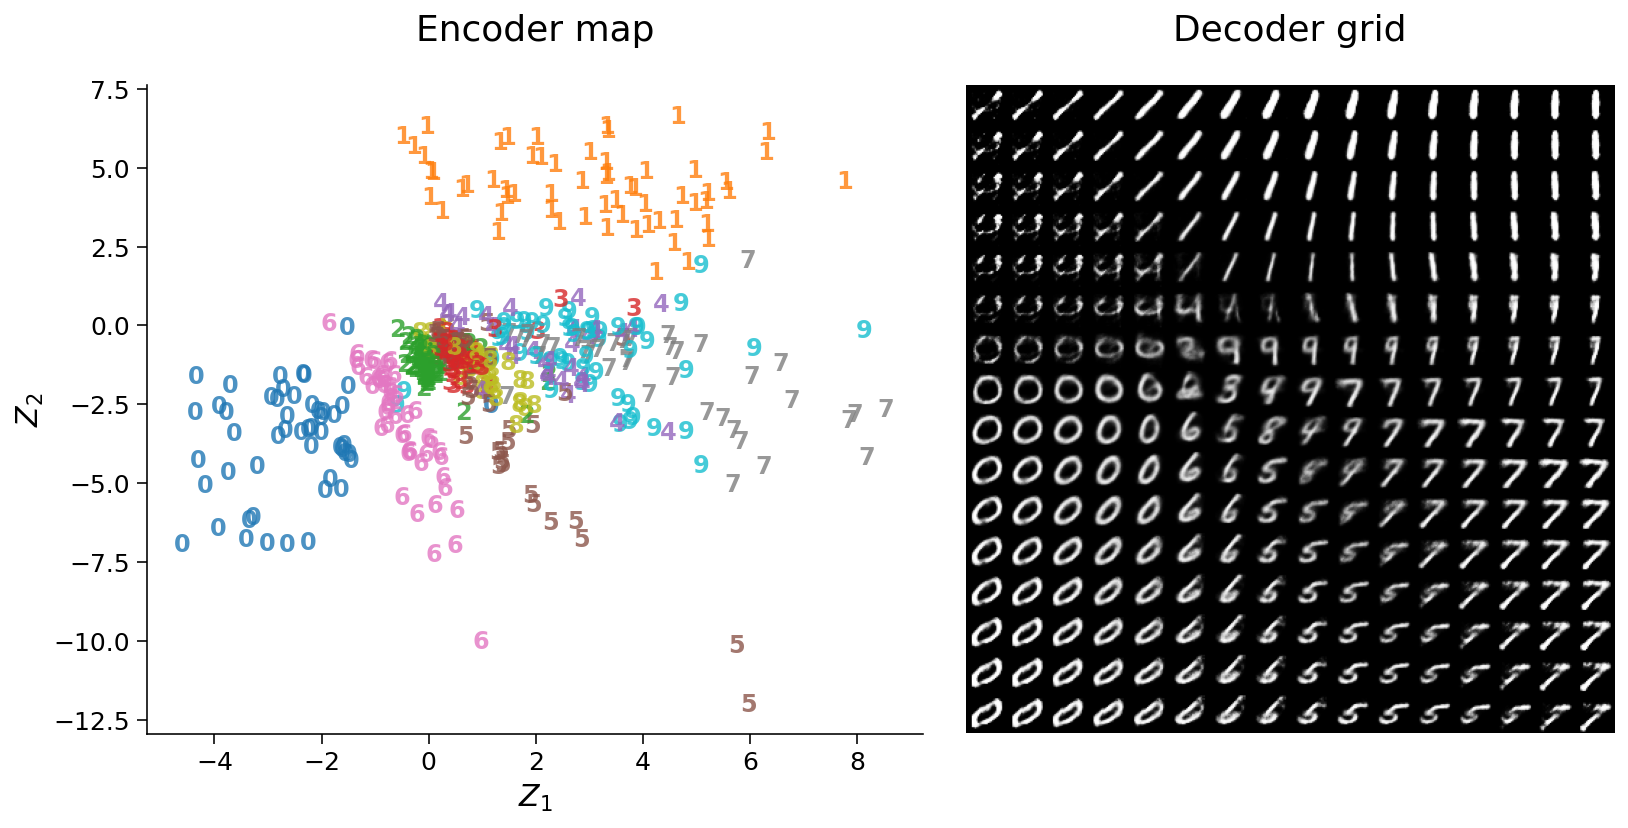

In [9]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

---
# Section 3: Spherical latent space

## Section 3.1: Build and train autoencoder (3D)

In [10]:
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

encoder = model[:6]
decoder = model[6:]

print(f'Autoencoder \n\n {model}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)


## Section 3.2: Train the autoencoder

Epoch 	 Loss train 	 Loss test
1/10	 0.1854		 0.1855
2/10	 0.1738		 0.1743
3/10	 0.1680		 0.1688
4/10	 0.1643		 0.1655
5/10	 0.1622		 0.1638
6/10	 0.1599		 0.1616
7/10	 0.1578		 0.1598
8/10	 0.1565		 0.1587
9/10	 0.1555		 0.1581
10/10	 0.1545		 0.1575


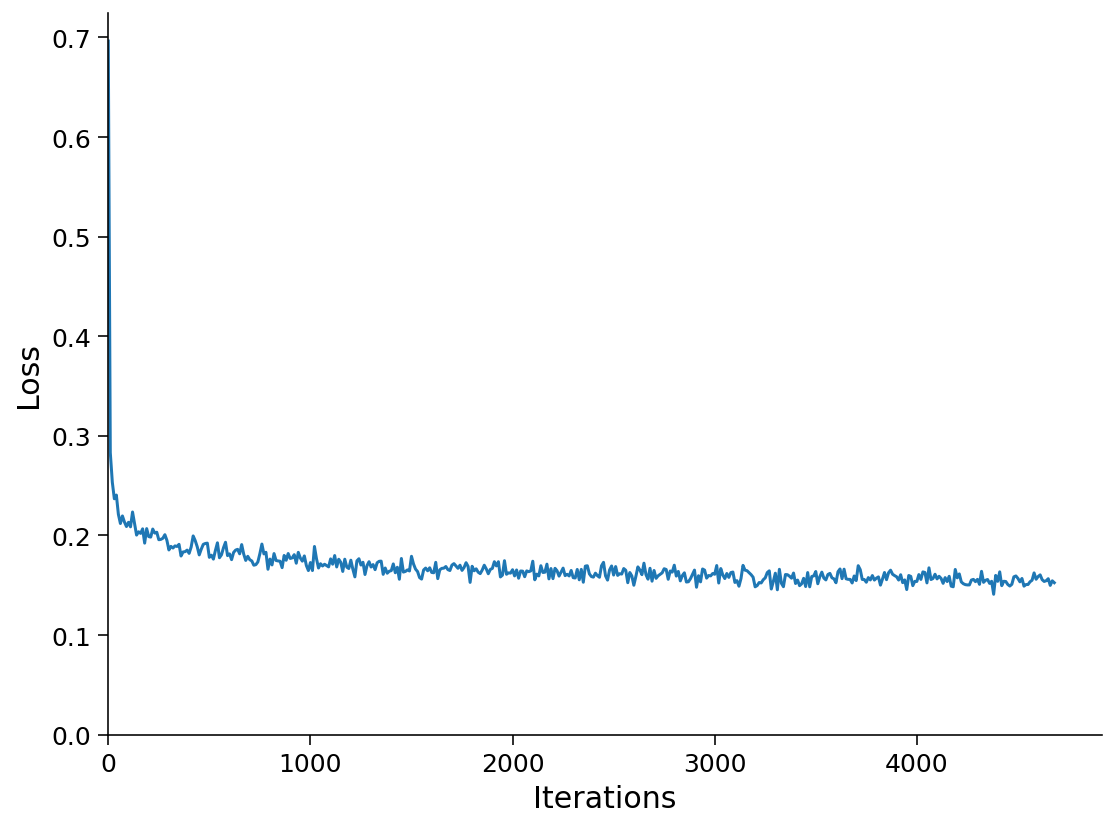

In [11]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

In [ ]:
# help(plot_latent_3d)

In [12]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_3d(latent_test, y_test)

### Exercise 2: Build deep autoencoder (2D) with latent spherical space
We now constrain the latent space to the surface of a sphere $S_2$.


**Instructions:**
* Add the custom layer `NormalizeLayer` after the bottleneck layer
* Adjust the definitions of `encoder` and `decoder`
* Experiment with keyword `show_text=False` for `plot_latent_3d`

**Helper function**: `NormalizeLayer`

Please uncomment the line below to inspect this function.

In [ ]:
help(NormalizeLayer)

In [19]:
# to_remove solution
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    # add the normalization layer
    NormalizeLayer(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
n_l = 7

# uncomment when you fill the code
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_parameters=1)
  (9): Linear(in_features=96, out_features=392, bias=True)
  (10): PReLU(num_parameters=1)
  (11): Linear(in_features=392, out_features=784, bias=True)
  (12): Sigmoid()
)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
)

Decoder 

 Sequential(
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_par

## Section 3.4: Train the autoencoder
Train the network for `n_epochs=10` epochs with `batch_size=128` and observe how loss raises again and is comparable to the model with 2D latent space.

**Instructions:**
* Please execute the cell below

Epoch 	 Loss train 	 Loss test
1/10	 0.2039		 0.2037
2/10	 0.1913		 0.1908
3/10	 0.1857		 0.1855
4/10	 0.1827		 0.1823
5/10	 0.1796		 0.1800
6/10	 0.1764		 0.1767
7/10	 0.1764		 0.1766
8/10	 0.1763		 0.1766
9/10	 0.1762		 0.1770
10/10	 0.1727		 0.1736


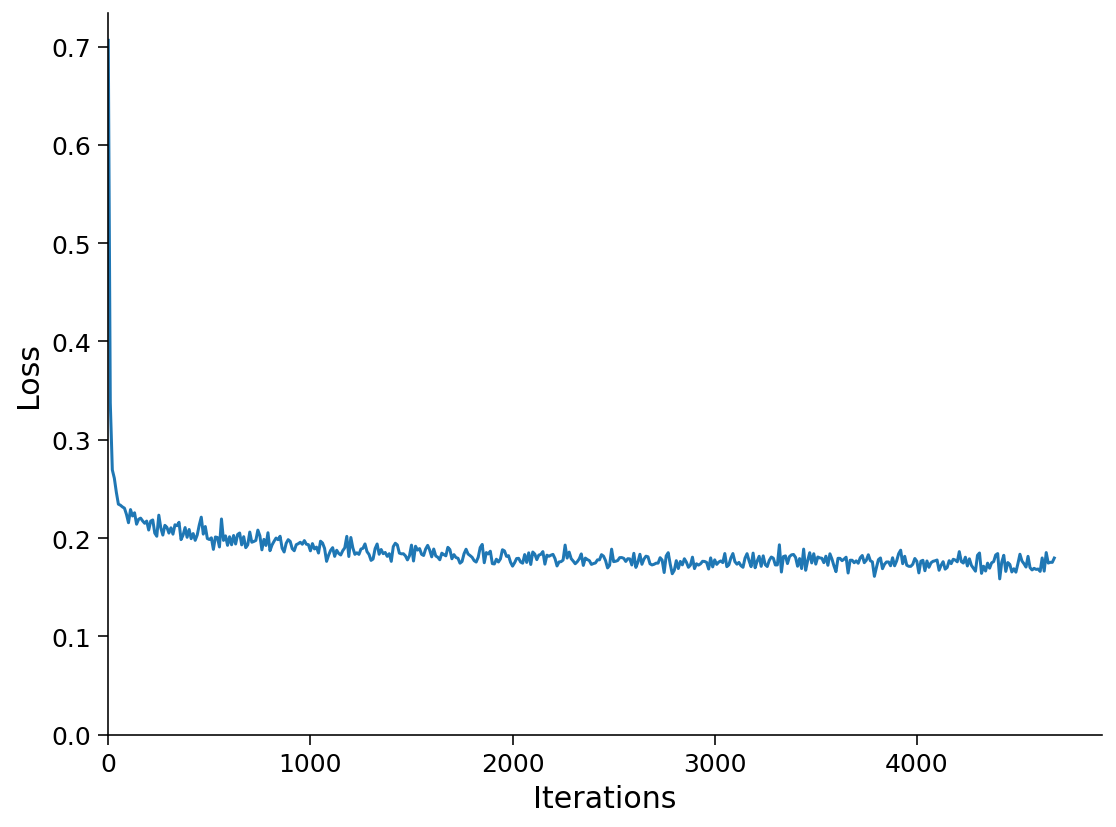

In [20]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

In [21]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_3d(latent_test, y_test)

## Section 3.5: Visualize latent space on surface of $S_2$

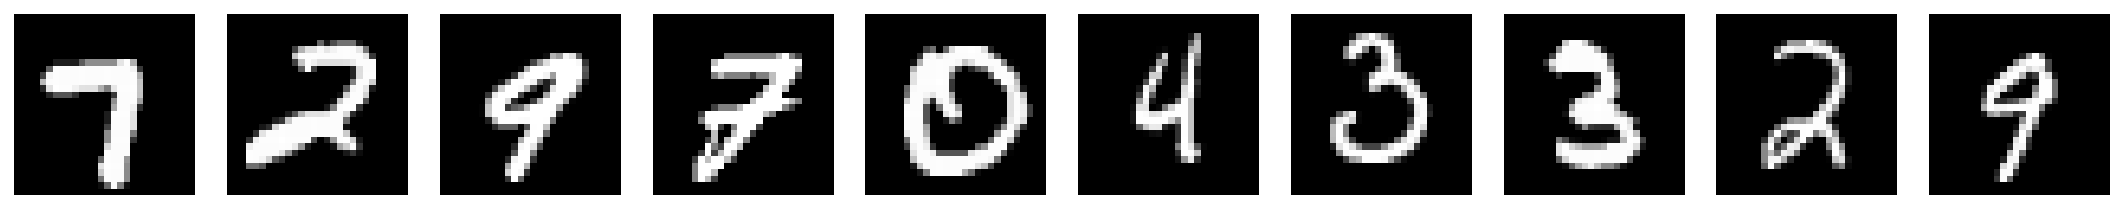

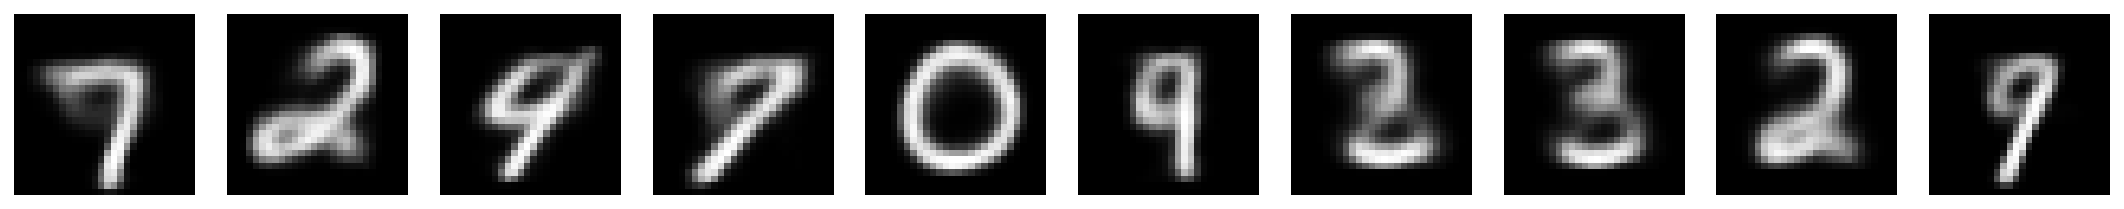

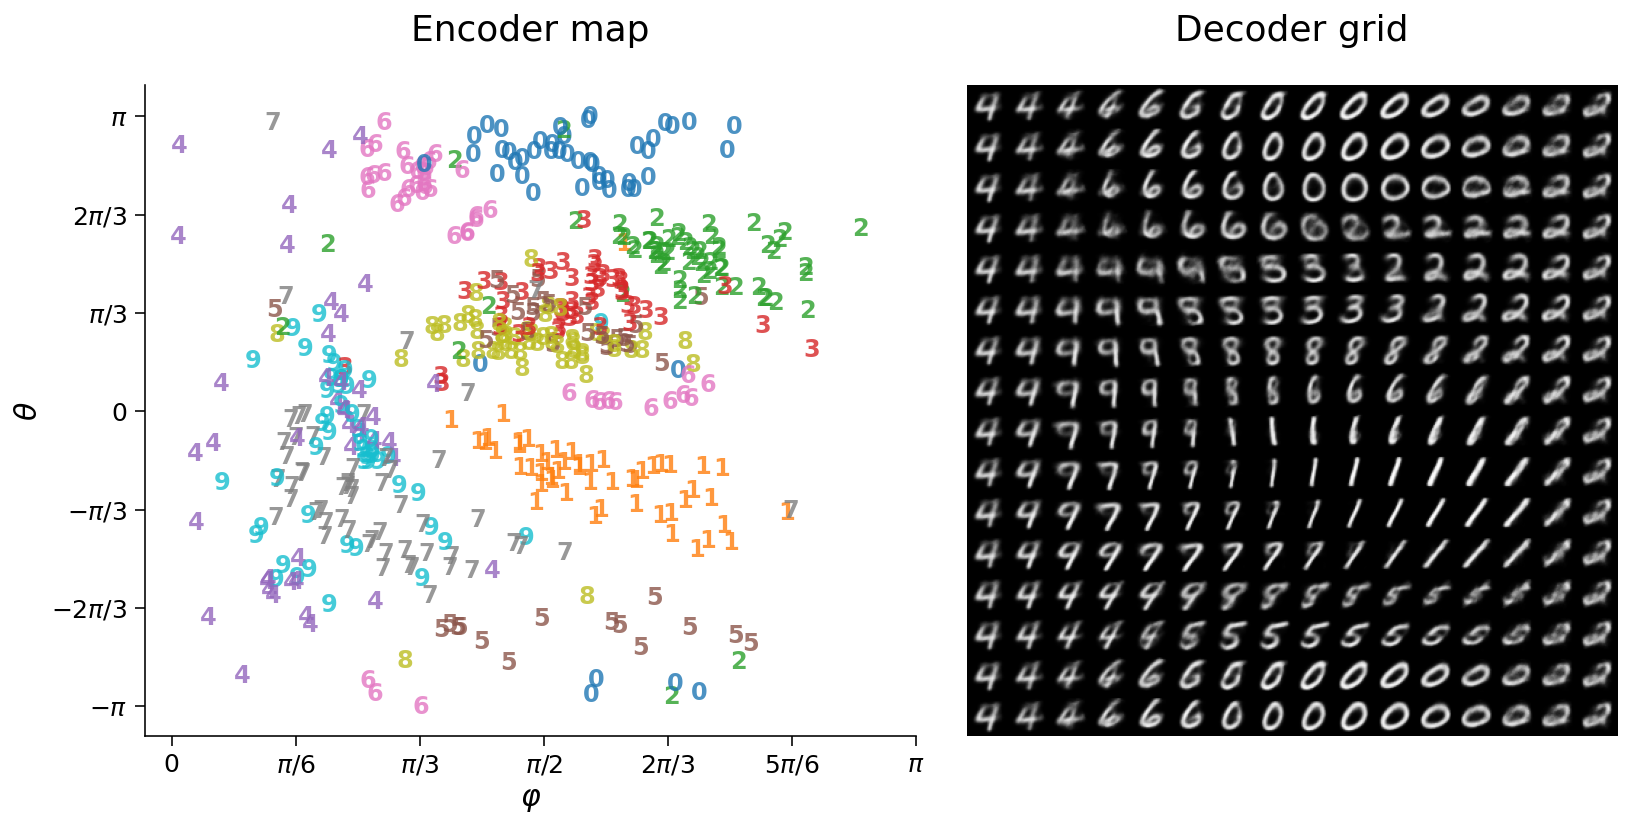

In [22]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape, s2=True)

---
# Bonus

## Deep and thick autoencoder

In [24]:
encoding_size = 3

model = nn.Sequential(
     nn.Linear(input_size, int(input_size * 2)),
     nn.PReLU(),
     nn.Linear(int(input_size * 2), int(input_size / 2)),
     nn.PReLU(),
     nn.Linear(int(input_size / 2), encoding_size * 32),
     nn.PReLU(),
     nn.Linear(encoding_size * 32, encoding_size),
     nn.PReLU(),
     NormalizeLayer(),
     nn.Linear(encoding_size, encoding_size * 32),
     nn.PReLU(),
     nn.Linear(encoding_size * 32, int(input_size / 2)),
     nn.PReLU(),
     nn.Linear(int(input_size / 2), int(input_size * 2)),
     nn.PReLU(),
     nn.Linear(int(input_size * 2), input_size),
     nn.Sigmoid()
     )

model[:-2].apply(init_weights_kaiming_normal)

encoder = model[:9]
decoder = model[9:]

print_parameter_count(model)

0	 1230880	 Linear(in_features=784, out_features=1568, bias=True)
1	 1	 PReLU(num_parameters=1)
2	 615048	 Linear(in_features=1568, out_features=392, bias=True)
3	 1	 PReLU(num_parameters=1)
4	 37728	 Linear(in_features=392, out_features=96, bias=True)
5	 1	 PReLU(num_parameters=1)
6	 291	 Linear(in_features=96, out_features=3, bias=True)
7	 1	 PReLU(num_parameters=1)
8	 0	 NormalizeLayer()
9	 384	 Linear(in_features=3, out_features=96, bias=True)
10	 1	 PReLU(num_parameters=1)
11	 38024	 Linear(in_features=96, out_features=392, bias=True)
12	 1	 PReLU(num_parameters=1)
13	 616224	 Linear(in_features=392, out_features=1568, bias=True)
14	 1	 PReLU(num_parameters=1)
15	 1230096	 Linear(in_features=1568, out_features=784, bias=True)
16	 0	 Sigmoid()

Total:	 3768682


In [ ]:
n_epochs = 5
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
        batch_size=batch_size)

# Visualization
with torch.no_grad():
   output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
          image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                        image_shape=image_shape, s2=True)

Epoch 	 Loss train 	 Loss test
1/5	 0.1762		 0.1763
